In [16]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn.decomposition import PCA, KernelPCA
import json
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score

In [17]:
with open(r"E:\ZhixiYun\Projects\Neuron_Morphology_Table\Tables\tree.json") as f:
    tree = json.load(f)
    
def ct_ccf_sort(ctlist):
    ctlist = [x.replace("23","2/3") for x in ctlist]
    select_ct_sorted = []
    for item in tree:
        if item["acronym"] in ctlist:
            select_ct_sorted.append(item["acronym"])
    return select_ct_sorted

In [18]:
used_cols = ["Center Shift","Relative Center Shift",
         "Average Contraction",  "Average Bifurcation Angle Remote","Average Bifurcation Angle Local",
         "Max Branch Order","Number of Bifurcations","Total Length",
         "Max Euclidean Distance","Max Path Distance","Average Euclidean Distance","25% Euclidean Distance",
         "50% Euclidean Distance","75% Euclidean Distance", "Average Path Distance","25% Path Distance","50% Path Distance","75% Path Distance",       
         '2D Density', '3D Density',
         'Area', 'Volume', 'Width',  'Width_95','Height', 'Height_95', 'Depth', 'Depth_95', 
         'Slimness', 'Slimness_95', 'Flatness', 'Flatness_95']

material_path = r"E:\ZhixiYun\Projects\Neuron_Morphology_Table\Materials"
df_ct = pd.concat([pd.read_csv(os.path.join(material_path,"cell_type/s_type","AIBS+SEU-ALLEN_Full_1741.csv"), index_col=0), 
                   pd.read_csv(os.path.join(material_path,"cell_type/s_type","MouseLight_Full_1200.csv"), index_col=0), 
                   pd.read_csv(os.path.join(material_path,"cell_type/s_type","ION_Axon_6357.csv"), index_col=0)
                  ])
df_ct.index = [x.replace('.semi_r','').replace('.auto_r','').replace('.semi_f','') for x in df_ct.index]


df_axon = pd.read_csv(os.path.join(material_path, 'morphology_feature/', 'Axon_Morphological_Features.csv'),index_col=0)
df_axon.index = [x.replace('.semi_r','').replace('.auto_r','').replace('.semi_f','') for x in df_axon.index]

df_axon = df_axon[used_cols]


In [19]:
df_den = pd.read_csv(os.path.join(material_path, 'morphology_feature/', 'Dendrite_Morphological_Features.csv'),index_col=0)
df_den = df_den[~df_den.index.str.contains('^Img')]
df_den.index = [x.replace('.semi_r','').replace('.auto_r','').replace('.semi_f','') for x in df_den.index]

df_den.dropna(inplace=True)
df_den = df_den[used_cols]


In [20]:
sl_1741 = pd.read_csv(os.path.join(material_path, 'soma_location', '1741_Soma_Location.csv'),index_col=0)
sl_1002 = pd.read_csv(os.path.join(material_path, 'soma_location', 'MouseLight_Soma_Location.csv'),index_col=0).iloc[:]
sl_ION = pd.read_csv(os.path.join(material_path, 'soma_location', 'ION_Soma_Location.csv'),index_col=0)
df_sl = pd.concat([sl_1741, sl_1002, sl_ION])
df_sl.index = [x.replace('.semi_r','').replace('.auto_r','').replace('.semi_f','') for x in df_sl.index]
# df_sl = df_sl.loc[df_subtype.index]
df_sl.dropna(inplace=True)
for ind in df_sl.index:
    z = df_sl.loc[ind,'z']
    if z>228:
        df_sl.loc[ind,'z'] = 456-z

df_sl

,x,y,z
17109_1701_x8048_y22277.swc,108.920000,148.804000,151.962000
17109_1801_x6698_y12550.swc,113.636000,136.714000,154.727000
17109_1901_x9602_y10508.swc,123.004000,183.974000,122.068000
17109_2201_x8046_y23301.swc,129.235000,142.621000,135.341000
17109_2301_x8535_y23051.swc,133.308000,151.149000,137.958000
...,...,...,...
201787_044_reg.swc,120.318486,128.302793,219.684775
201787_045_reg.swc,118.910440,116.284689,217.566681
201787_048_reg.swc,121.453392,113.448196,217.670578
201787_050_reg.swc,135.528418,125.900020,213.173718


In [21]:
for ind in df_ct.index:
    dct = df_ct.loc[ind, 'Detail CellType']
    if dct.find('SSp')!=-1:
        if dct.find("2/3")!=-1:
            dct = 'SSp2/3'
        elif dct.find("1")!=-1:
            dct = 'SSp1'
        elif dct.find("4")!=-1:
            dct = 'SSp4'
        elif dct.find("5")!=-1:
            dct = 'SSp5'
        elif dct.find("6a")!=-1:
            dct = 'SSp6a'
        elif dct.find("6b")!=-1:
            dct = 'SSp6b'
        else:
            dct = 'SSp'
        df_ct.loc[ind, 'Detail CellType'] = dct

In [22]:
df_dct_v_c = df_ct['Detail CellType'].value_counts()
ctlist = ct_ccf_sort(list(df_dct_v_c[df_dct_v_c>60].index))
len(ctlist)

31

In [23]:
import glob
df_overlap = pd.DataFrame()
for ct in ctlist:
    csvpath = glob.glob(os.path.join(material_path, 'connectivity_matrix/mirrored/',
                                     '{}*'.format(ct.replace('2/3','23'))))[0]
    tmpdf = pd.read_csv(csvpath,index_col=0)
    tmpdf = tmpdf.dropna(how='all',axis=0)
    tmpdf['celltype'] = ct
    df_overlap = pd.concat([df_overlap,tmpdf])
df_overlap = df_overlap.dropna(how='all',axis=1)
df_overlap = df_overlap.fillna(0)
tmpseries = df_overlap['celltype']
del df_overlap['celltype']
df_overlap = (df_overlap+1).apply(np.log)
# df = (df.T/(df.T.sum(axis=0)+1e-20)).T
df_overlap['celltype'] = tmpseries
df_overlap.index = [x.replace('.semi_r','').replace('.auto_r','').replace('.semi_f','') for x in df_overlap.index]


In [24]:
# unify the index of each dataframe
unified_indice = []
for tmpdf in [df_overlap,df_ct,df_axon,df_sl]:
    if len(unified_indice)==0:
        unified_indice = list(tmpdf.index)
    else:
        unified_indice = np.intersect1d(unified_indice,tmpdf.index)

df_ct = df_ct.loc[unified_indice]
df_overlap = df_overlap.loc[unified_indice]
df_axon = df_axon.loc[unified_indice]
df_sl= df_sl.loc[unified_indice]

len(unified_indice)

6494

In [25]:
eps = 1e-20

In [26]:
def generate_similarity_matrix(arr, metric='cosine'):
    sim_mat = np.zeros((len(arr),len(arr)),dtype=np.float32)
    cdist_result = cdist(arr,arr,metric=metric)
    if metric == 'cosine':
        sim_mat = 1-cdist_result
    if metric == 'euclidean':
        sim_mat = np.exp(-cdist_result)
    return sim_mat

# Soma Location Based

In [27]:
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import cdist
from itertools import product

'''Preparation of anatomy covariance based mahalanobis distance'''
import SimpleITK as sitk
annotmp = sitk.GetArrayFromImage(sitk.ReadImage(r"E:\ZhixiYun\neuro_morpho_toolbox-0.1-py3.6.egg\neuro_morpho_toolbox\data\annotation_25.nrrd"))
anno = np.zeros((annotmp.shape[2], annotmp.shape[1], annotmp.shape[0]), dtype=annotmp.dtype)
ix,iy,iz=np.where(annotmp>0)
anno[iz,iy,ix]=annotmp[ix,iy,iz]

def find_children(id_):
    idlist = []
    for t in tree:
        if id_ in t["structure_id_path"]:
            idlist.append(t['id'])
    if not idlist:
        idlist = [id_]
    return idlist


lutnametoid = dict(zip([t["acronym"] for t in tree], [t["id"] for t in tree]))
lutidtoname = dict(zip([t["id"] for t in tree], [t["acronym"] for t in tree]))

def anatomy_cov_mah_distance(data,ct):
    v = np.array(data)
    # v = v-v.mean(axis=0)
    
    anno_contra = anno.copy()
    anno_contra[:,:,:228]=0
    anno_ipsi = anno.copy()
    anno_ipsi[:,:,228:]=0
    
    cov_ipsi = np.cov(np.argwhere(np.isin(anno_ipsi, find_children(lutnametoid.get(ct)))).T)
    cov_contra = np.cov(np.argwhere(np.isin(anno_contra, find_children(lutnametoid.get(ct)))).T)
    # cov_ipsi = np.identity(3)
    # cov_contra = np.identity(3)
    
    ipsi = []
    contra = []
    for i in range(len(v)):
        z = v[i][2]
        if z<=228: ipsi.append(i)
        else: contra.append(i)
    # print(len(ipsi),len(contra))
    v1, v2 = v[ipsi], v[contra]
    # v1 = v1 - v1.mean(axis=0)
    # v2 = v2 - v2.mean(axis=0)
    
    dist_mat = np.zeros((len(v),len(v)),dtype=np.float32)-1

    for i in range(len(v1)):
        for j in range(i,len(v1)):
            diff1 = v1[i]-v1[j]
            dist = np.sqrt(diff1.T@np.linalg.inv(cov_ipsi)@diff1)
            dist_mat[ipsi[i],ipsi[j]] = dist
            dist_mat[ipsi[j],ipsi[i]] = dist
            
    for i in range(len(v2)):
        for j in range(i,len(v2)):
            diff2 = v2[i]-v2[j]
            dist = np.sqrt(diff2.T@np.linalg.inv(cov_contra)@diff2)
            dist_mat[contra[i],contra[j]] = dist
            dist_mat[contra[j],contra[i]] = dist
            
    # print(np.max(dist_mat))
    dist_mat[dist_mat==-1]=(np.max(dist_mat)+1)**2
    
    return dist_mat

In [28]:
def show_significance(pv):
    significance = "n.s."
    if pv<0.0001:
        significance = '***'
    elif pv<0.001:
        significance = '**'  
    # elif pv<0.01:
    #     significance = '**'
    elif pv<0.05:
        significance = '*'
    return significance

D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


FRP5 -0.028966693563184168 0.03325784131105188 -0.10011104456530358 1.6456558581024788e-13


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


MOs2/3 -0.09349267576514314 2.5836433063785873e-92 -0.2930283198541974 0.0


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


MOs5 -0.0663436957479166 2.6190193487279225e-125 -0.15489948357710143 0.0


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


MOs6a -0.05575092548460059 1.1668797378291712e-10 -0.14297793536685813 7.255049950981918e-62


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


SSp5 -0.10392933281871197 7.219827464099486e-66 -0.38822001951170804 0.0


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


ACAd2/3 -0.1595380757901914 2.564918139266819e-127 -0.23749423177966475 4.1080974833040283e-284


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


ACAd5 -0.06480574640993342 2.24954249353298e-101 -0.08087377530687137 5.939395932823934e-157


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


ACAd6a -0.23073097548074278 1.7476957048502522e-110 -0.24697793245417526 8.223060697135302e-127


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


ACAv2/3 -0.05576856820473904 3.922260168638951e-09 -0.26942034912627505 2.2642188857456773e-184


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


ACAv5 -0.10398900212757013 0.0 -0.1045608990557089 0.0


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


PL2/3 -0.20403458312219167 0.0 -0.1748331416885321 2.583604236613364e-239


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


PL5 -0.02235903691638672 1.2860428356148072e-70 -0.09474083855375239 0.0


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


PL6a -0.08880360887702585 1.897294588439045e-18 -0.05235434658642576 2.473316261755302e-07


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


ILA5 -0.17045040372712292 4.885780552128328e-86 -0.14067935702383727 6.26468221003938e-59


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


ORBl2/3 -0.07870122959818746 4.730615754316358e-30 -0.1373777781083817 1.6762823480274407e-88


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


ORBl5 -0.05942921193729016 3.6555129226601866e-47 -0.06467123926283226 1.540243928461102e-55


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


ORBm2/3 -0.09851085356265145 4.473670396482585e-24 -0.1445463019919864 3.696838770905966e-50


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


ORBm5 -0.11038932557073115 1.5069892674627175e-123 -0.01651353251255488 0.00042224836940573296


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


ORBvl1 -0.17341282849467335 5.521868130204313e-60 -0.1373805568870129 4.2573334802970423e-38


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


ORBvl2/3 -0.09334662381497848 9.550658664858337e-89 -0.1367653129051425 3.557575381282419e-189


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


ORBvl5 -0.04861247467743475 6.021455108962604e-50 -0.07234730192038843 1.5979527124729978e-108


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


ORBvl6a -0.039569133279230236 0.0036290004642991927 -0.04761900947975396 0.00046335525371633335


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


AId2/3 -0.05774777009307834 2.9427471924010474e-66 -0.13445594536692285 0.0


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


AId5 -0.029112971608970455 1.1979791245740928e-38 -0.04988037567741145 5.130519672593018e-110


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


AIv2/3 -0.10199342218575004 1.1795832752056408e-21 -0.06791217820597012 2.0690189849968802e-10


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


AIv5 -0.024197720520641553 0.007496620101919906 -0.11537907384162661 1.8483249747877526e-37


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


SUB -0.030987011796986725 0.02275563994728962 -0.12004552393283112 8.509764438670414e-19


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


CP -0.056349815479959216 6.450090115120601e-60 -0.20899780931524825 0.0


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


VPL -0.20324362096620277 4.269770515761801e-77 -0.3392254990349371 1.1262626750119319e-219


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


VPM -0.4408231436977803 0.0 -0.5146657199304692 0.0


D:\anaconda3\envs\yzx\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


LGd -0.20742105189209314 2.290271025228165e-59 -0.2570514170530951 3.0039387536229996e-91


D:\anaconda3\envs\yzx\lib\site-packages\ipykernel_launcher.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
D:\anaconda3\envs\yzx\lib\site-packages\ipykernel_launcher.py:98: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


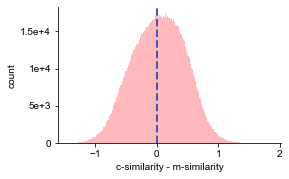

In [29]:
m_sim_list=[]
c_sim_list=[]
l_m_corr_list=[]
l_c_corr_list=[]
c_m_corr_list=[]
diff_value_list = []

corr_test = []

for i in range(len(ctlist)):
    ct=ctlist[i]
    # if ct.find('SSp')!=-1: continue
    # if ct not in ['ACAd6a','CP','LGd']: continue
    tmpdf = df_ct[df_ct['Detail CellType']==ct]
    # tmpdf = tmpdf.sort_values(by='detail ctype')
    celllist = tmpdf.index
    
    df_somaloc = df_sl.loc[celllist]*25
    df_somaloc.dropna(inplace=True)
    celllist = df_somaloc.index
    somaloc_dist_mat = cdist(df_somaloc.values,df_somaloc.values,metric='euclidean')
    # somaloc_dist_mat = anatomy_cov_mah_distance(df_somaloc.values,ct)
    # somaloc_dist_mat = np.exp(-0.5*somaloc_dist_mat**1)
    df_somaloc_dist_mat = pd.DataFrame(somaloc_dist_mat, index=celllist, columns=celllist)
    
    g_sl = sns.clustermap(df_somaloc_dist_mat,method='ward')
    cluster_celllist=np.array(celllist)[np.array(g_sl.dendrogram_col.reordered_ind)]
    g_sl.ax_heatmap.set_xticks([])
    g_sl.ax_heatmap.set_yticks([])
    # plt.suptitle('soma distance')
    # plt.savefig(f'./fig4/intra_similarity_overview/soma_location_anatomy_mahalanobis_based/{ct.replace("2/3","23")}_l.png', dpi=250, bbox_inches='tight',facecolor='w')
    # plt.savefig(f'./fig4/flipped/intra_similarity_overview/soma_location_based/{ct.replace("2/3","23")}_l.png', dpi=250, bbox_inches='tight',facecolor='w')
    plt.close()
    # plt.show()
    # continue
    
    df_morpho = df_axon.loc[celllist]
    morpho_stand_value = (df_morpho.values - df_morpho.values.mean(axis=0)) / (df_morpho.values.std(axis=0)+ eps)
    morpho_sim_mat = generate_similarity_matrix(morpho_stand_value)
    df_morpho_sim_mat = pd.DataFrame(morpho_sim_mat,index=df_morpho.index,columns=df_morpho.index)
    

    df_conn = df_overlap.loc[celllist,df_overlap.columns[:-1]]
    conn_stand_value = (df_conn.values - df_conn.values.mean(axis=0)) / (df_conn.values.std(axis=0)+ eps)
    conn_sim_mat = generate_similarity_matrix(conn_stand_value)
    df_conn_sim_mat = pd.DataFrame(conn_sim_mat,index=df_conn.index,columns=df_conn.index)
    
    diag_idx = [x*len(celllist)+x for x in range(len(celllist))]
    df_somaloc_dist_mat_remove_diag=np.delete(df_somaloc_dist_mat.values.flatten(),diag_idx)
    df_morpho_sim_mat_remove_diag=np.delete(df_morpho_sim_mat.values.flatten(),diag_idx)
    df_conn_sim_mat_remove_diag=np.delete(df_conn_sim_mat.values.flatten(),diag_idx)

    l_m,l_m_p=pearsonr(df_somaloc_dist_mat_remove_diag, df_morpho_sim_mat_remove_diag)
    l_c,l_c_p=pearsonr(df_somaloc_dist_mat_remove_diag, df_conn_sim_mat_remove_diag)
    l_m_corr_list.append(l_m)
    l_c_corr_list.append(l_c)
    print(ct,l_m,l_m_p,l_c,l_c_p)
    corr_test.append([ct,l_m,l_m_p,show_significance(l_m_p),l_c,l_c_p,show_significance(l_c_p)])
    diff_value_list.extend(list(df_conn_sim_mat_remove_diag-df_morpho_sim_mat_remove_diag))
    
    c_m_corr_list.append(pearsonr(df_morpho_sim_mat_remove_diag,df_conn_sim_mat_remove_diag)[0])
    m_sim_list.extend(list(df_morpho_sim_mat_remove_diag))
    c_sim_list.extend(list(df_conn_sim_mat_remove_diag))
    g=sns.clustermap(df_morpho_sim_mat.loc[cluster_celllist][cluster_celllist],row_cluster=False,col_cluster=False,vmax=1,vmin=-1, cmap='OrRd')
    g.ax_cbar.set_visible(False)
    g.ax_heatmap.set_xticks([])
    g.ax_heatmap.set_yticks([])
    # plt.suptitle('m-similarity '+ct,y=1)
    # plt.savefig(f'./fig4/flipped/intra_similarity_overview/soma_location_based/{ct.replace("2/3","23")}_l_m.png', dpi=250, bbox_inches='tight',facecolor='w')
    plt.close()
    # plt.show()
    
    g=sns.clustermap(df_conn_sim_mat.loc[cluster_celllist][cluster_celllist],row_cluster=False,col_cluster=False,vmax=1,vmin=-1, cmap='OrRd')
    g.ax_cbar.set_visible(False)
    g.ax_heatmap.set_xticks([])
    g.ax_heatmap.set_yticks([])
    # plt.suptitle('c-similarity '+ct,y=1)
    # plt.savefig(f'./fig4/flipped/intra_similarity_overview/soma_location_based/{ct.replace("2/3","23")}_l_c.png', dpi=250, bbox_inches='tight',facecolor='w')
    plt.close()
    # plt.show()
    

pd.DataFrame(corr_test,columns=['Cell Type','l_m_corr','p-value','significance','l_c_corr','p-value','significance']).to_csv(r'E:\ZhixiYun\Projects\Neuron_Morphology_Table\Figures\revision\STablex_l_m_l_c_corr_test.csv')

'''all stype histogram of c_m_diff'''
diff_value_list = np.asarray(diff_value_list)
fig,ax=plt.subplots(1,figsize=(4,2.5))
ax.hist(diff_value_list,bins=np.histogram_bin_edges(diff_value_list,bins='auto'),color='#ffb8bb',density=False)
left = np.sum(diff_value_list<0)/len(diff_value_list)
# ax.set_title('{:.1f}%  '.format((np.round(left,3)*100))+'   {:.1f}%'.format(100-np.round(left,3)*100))
ax.axvline(x=0,ls='--',color='#4055b5',lw=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticklabels(['0','5e+3','1e+4','1.5e+4','2e+4'])
ax.set_ylabel('count')
ax.set_xlabel('c-similarity - m-similarity')
# fig.savefig('./fig4/flipped/c_m_diff_histogram.png', dpi=250, bbox_inches='tight',facecolor='w')
fig.show()

In [30]:
left,1-left

(0.4644729656711963, 0.5355270343288037)

R_square: 0.24467102260957305 p_value: 0.0


Text(-0.25, 0.5, 'c-similarity')

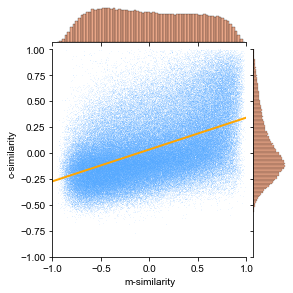

In [63]:
import random
random.seed(8)
randind=np.array(random.sample(np.arange(len(m_sim_list)).tolist(),int(len(m_sim_list)/10)))
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(m_sim_list)[randind],
                                                               np.array(c_sim_list)[randind])
# slope, intercept, r_value**2, p_value, std_err
print('R_square:',r_value**2,'p_value:', p_value)
g = sns.jointplot(x=np.array(m_sim_list)[randind], y=np.array(c_sim_list)[randind],
                  kind="scatter", 
                  # truncate=False,
                  xlim=(-1, 1), ylim=(-1, 1),
                  color='dodgerblue', height=4,ci=None,
                  # order=1,
                  joint_kws={'s':0.1},
                  # marginal_kws={'color':[(34/255,129/255,185/255)]})
                  marginal_kws={'color':[(225/255,136/255,96/255)]})
g.ax_joint.plot((-1,1),(-1*slope+intercept,1*slope+intercept),color='orange',lw=2)
g.ax_joint.set_xlabel('m-similarity')
g.ax_joint.set_ylabel('c-similarity')
# g.savefig(f'./fig4/flipped/m_c_linear_regression_orange.png',
#             dpi=250, bbox_inches='tight',facecolor='w')


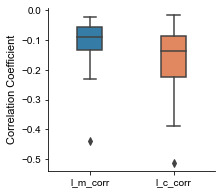

In [32]:
df_boxplot=pd.DataFrame(l_m_corr_list+l_c_corr_list,columns=['value'],)
df_boxplot['class'] = ['l_m_corr']*len(ctlist)+['l_c_corr']*len(ctlist)
df_boxplot['celltype'] = ctlist*2
plt.figure(figsize=(3,3))
g=sns.boxplot(data=df_boxplot,x='class',y='value',width=0.3,palette=np.array([(34,129,185),(246,128,75)])/255.0)

g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)
plt.xlabel('')
plt.ylabel('Correlation Coefficient',fontsize=11)

# plt.savefig('./fig4/flipped/stypes_l_m_l_c_corr_boxplot.png',dpi=250, bbox_inches='tight',facecolor='w')
plt.show()

In [33]:
from scipy.stats import ttest_rel
print(ttest_rel(l_m_corr_list,l_c_corr_list))

Ttest_relResult(statistic=3.880158102580387, pvalue=0.0005302214170292882)


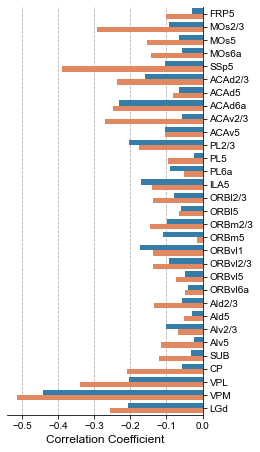

In [34]:
plt.figure(figsize=(3.5,7.5))
g=sns.barplot(data=df_boxplot,hue='class',y='celltype',x='value',palette=np.array([(34,129,185),(246,128,75)])/255.0,orient='horizontal',zorder=10)
g.legend_.set_visible(False)
plt.xticks(rotation=0)
g.yaxis.set_ticks_position('right')
plt.grid(axis='x',linestyle='--')
plt.ylabel('')
g.spines['left'].set_visible(False)
g.spines['top'].set_visible(False)

plt.xlabel('Correlation Coefficient',fontsize=12)
# plt.savefig('./fig4/flipped/stypes_l_m_l_c_corr_barplot.png',dpi=250, bbox_inches='tight',facecolor='w')
plt.show()

D:\anaconda3\envs\yzx\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


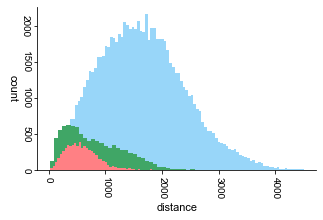

In [35]:
lutnametorgb = dict(zip([t["acronym"] for t in tree], [t["rgb_triplet"] for t in tree]))

fig,ax=plt.subplots(1,figsize=(5,3))

for i,ct in enumerate(['CP','ACAd6a','LGd']):
    tmpdf = df_ct[df_ct['Detail CellType']==ct]
    celllist = tmpdf.index
    
    df_somaloc = df_sl.loc[celllist]*25
    somaloc_dist_mat = cdist(df_somaloc.values,df_somaloc.values,metric='euclidean')
    df_somaloc_dist_mat = pd.DataFrame(somaloc_dist_mat, index=celllist, columns=celllist)
    
    
    diag_idx = [x*len(celllist)+x for x in range(len(celllist))]
    df_somaloc_dist_mat_remove_diag=np.delete(df_somaloc_dist_mat.values.flatten(),diag_idx)

    '''Histogram of each dist/similarity map'''
    ax.hist(df_somaloc_dist_mat_remove_diag,bins=np.histogram_bin_edges(df_somaloc_dist_mat_remove_diag,bins='auto'),color=np.array(lutnametorgb.get(ct))/255.0,density=False,label=ct)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xticks(rotation=270,horizontalalignment='center')
    plt.yticks(rotation=270,verticalalignment='center')
    plt.ylabel('count',rotation=270,verticalalignment='top',fontsize=11)
    plt.xlabel('distance',fontsize=11)
    # plt.legend()
    
# fig.savefig(f'./fig4/flipped/three_somaloc_dist.png', dpi=250, bbox_inches='tight',facecolor='w')
fig.show()
